Model training, hyper-parameter tuning and cross-validation

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [343]:
# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = desired_columns = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()

Screening questionnaire (feature selection)

In [344]:
# load the screening questionnaire 
#screening_questions = pd.read_csv('screening_questions.csv', sep=';')
screening_questions = pd.read_csv('10_screening_questions.csv', sep=';')
#screening_questions = pd.read_csv('15_screening_questions.csv', sep=';')
#screening_questions = pd.read_csv('20_screening_questions.csv', sep=';')
#screening_questions = pd.read_csv('25_screening_questions.csv', sep=';')
screening_questions

,Critère DSM-5,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category
0,A,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention
1,A,I have been accused of inaccuracies in my work,tr2,Often fails to give close attention to details...,inattention
2,A,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention
3,B,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention
4,B,I have trouble staying focused during conversa...,tr6,Often has difficulty sustaining attention in t...,inattention
5,C,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention
6,D,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention
7,D,I have difficulty staying focused during my ac...,tr11,Often does not follow through on instructions ...,inattention
8,E,I have difficulty organizing my time,tr12,Often has difficulty organizing tasks and acti...,inattention
9,E,My work is often messy or disorganized,tr13,Often has difficulty organizing tasks and acti...,inattention


Data preprocessing

In [345]:
adasyn = ADASYN(random_state=38)
X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
balanced_df.describe()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,...,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,0.502809,0.457865,3.542135,3.702247,4.794944,4.379213,3.870787,3.735955,3.292135,4.308989,...,1.553371,1.390449,1.294944,0.988764,0.761236,1.415730,1.595506,1.109551,1.033708,1.176966
std,0.500696,0.498923,1.587245,1.536814,1.430090,1.470658,1.581634,1.652297,1.693083,1.622041,...,1.020889,0.879705,0.961265,0.987178,0.820005,1.027059,0.975406,1.043730,1.025857,1.071857
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,4.000000,3.000000,2.000000,2.000000,2.000000,3.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


Split the balanced dataset by gender for train, test and validation sets

In [346]:
# split the dataset by gender 
balanced_df_women = balanced_df[balanced_df['gender'] == 0]
balanced_df_men = balanced_df[balanced_df['gender'] == 1]

# split it further into features and target variable
X_women = balanced_df_women.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_women = balanced_df_women['group'].copy() # adhd = 1 / no adhd = -1

X_men = balanced_df_men.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_men = balanced_df_men['group'].copy() # adhd = 1 / no adhd = -1

# further filter the features to extract only the ones in the narrowed down version of the questionnaire
screening_qs_codes = screening_questions['question_code'].unique()
X_women = X_women.filter(items=screening_qs_codes, axis=1)
X_men = X_men.filter(items=screening_qs_codes, axis=1)


In [347]:
# stratified splitting to preserve a balanced class split according to diagnosis
# women
X_train_val_women, X_test_women, y_train_val_women, y_test_women = train_test_split(X_women, y_women, test_size=0.2, stratify=y_women, random_state=15) 
X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_val_women, y_train_val_women, test_size=0.35, stratify=y_train_val_women, random_state=15) 

# men
X_train_val_men, X_test_men, y_train_val_men, y_test_men = train_test_split(X_men, y_men, test_size=0.2, stratify=y_men, random_state=15) 
X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_val_men, y_train_val_men, test_size=0.35, stratify=y_train_val_men, random_state=15) 

Model training

In [348]:
# save results
# Function to save evaluation metrics to a file
def save_evaluation_results(model_name, gender, accuracy, precision, recall, f1, roc_auc, best_params=None):
    file_name = f"{model_name}_{gender}.txt"
    with open(file_name, 'w') as file:
        file.write(f'Evaluation metrics for {gender}:\n')
        file.write(f'Accuracy: {accuracy}\n')
        file.write(f'Precision: {precision}\n')
        file.write(f'Recall: {recall}\n')
        file.write(f'F1 Score: {f1}\n')
        file.write(f'ROC AUC Score: {roc_auc}\n')
        # If best_params are provided, write them to the file
        if best_params:
            file.write('\nBest Model Parameters:\n')
            for key, value in best_params.items():
                file.write(f'{key}: {value}\n')

# Function to save confusion matrix plot as a picture
def save_confusion_matrix_plot(conf_matrix, model_name, gender):
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} on {gender}')
    plt.savefig(f'confusion_matrix_{model_name}_{gender}.png')
    plt.close()

# Function to save cross-validation results to a file
def save_cross_validation_results(model_name, gender, cv_results):
    file_name = f"{model_name}_{gender}_cross_validation.txt"
    with open(file_name, 'w') as file:
        file.write(f'Cross-Validation Results for {gender}:\n')
        file.write(f'Accuracy: {cv_results["test_accuracy"]}\n')
        file.write(f'Precision: {cv_results["test_precision"]}\n')
        file.write(f'Recall: {cv_results["test_recall"]}\n')
        file.write(f'F1 Score: {cv_results["test_f1"]}\n')
        file.write(f'ROC AUC Score: {cv_results["test_roc_auc"]}\n')
        
        file.write(f'Mean CV Accuracy: {np.mean(cv_results["test_accuracy"])}\n')
        file.write(f'Mean CV Precision: {np.mean(cv_results["test_precision"])}\n')
        file.write(f'Mean CV Recall: {np.mean(cv_results["test_recall"])}\n')
        file.write(f'Mean CV F1 Score: {np.mean(cv_results["test_f1"])}\n')
        file.write(f'Mean CV ROC AUC Score: {np.mean(cv_results["test_roc_auc"])}\n')

In [349]:
def evaluate_model(model, X_val, y_val, gender, best_params=None):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)

    print(f'Evaluation metrics for {gender}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC AUC Score: {roc_auc}')

    conf_matrix = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    disp.plot(cmap='Blues')

    # Save evaluation metrics to a file
    save_evaluation_results(model.__class__.__name__, gender, accuracy, precision, recall, f1, roc_auc, best_params=best_params)

    # Save confusion matrix plot as picture
    save_confusion_matrix_plot(conf_matrix, model.__class__.__name__, gender)

In [350]:
# 5-fold cross validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=15)

def cross_validation(model, X_train, y_train, gender, kf):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring)
    # Save cross-validation results to a file
    save_cross_validation_results(model.__class__.__name__, gender, cv_results)
    print("Cross-Validation Results:")
    
    print("Accuracy:", cv_results['test_accuracy'])
    print("Precision:", cv_results['test_precision'])
    print("Recall:", cv_results['test_recall'])
    print("F1 Score:", cv_results['test_f1'])
    print("ROC AUC Score:", cv_results['test_roc_auc'])

    print("Mean CV Accuracy:", np.mean(cv_results['test_accuracy']))
    print("Mean CV Precision:", np.mean(cv_results['test_precision']))
    print("Mean CV Recall:", np.mean(cv_results['test_recall']))
    print("Mean CV F1 Score:", np.mean(cv_results['test_f1']))
    print("Mean CV ROC AUC Score:", np.mean(cv_results['test_roc_auc']))

Logistic Regression

In [351]:
# define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'], # l1 lasso l2 ridge
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}

Logistic Regression for Women

In [352]:
logistic_reg = LogisticRegression(max_iter=1000, random_state=15, solver='liblinear')

grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 0.5, 'penalty': 'l1'}


In [353]:
best_logistic_reg_women = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=15)
best_logistic_reg_women.fit(X_train_women, y_train_women)

LogisticRegression(C=0.5, max_iter=1000, penalty='l1', random_state=15,
                   solver='liblinear')

Evaluation metrics for women:
Accuracy: 0.78
Precision: 0.782608695652174
Recall: 0.75
F1 Score: 0.7659574468085107
ROC AUC Score: 0.7788461538461539


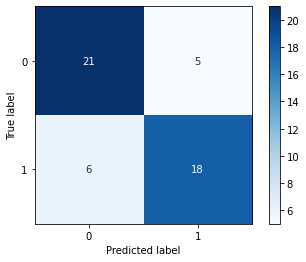

<Figure size 576x432 with 0 Axes>

In [354]:
evaluate_model(best_logistic_reg_women, X_val_women, y_val_women, 'women', best_params=best_params)

In [355]:
cross_validation(best_logistic_reg_women, X_train_women, y_train_women, 'women', kf=kf)

Cross-Validation Accuracy Scores:
[0.73684211 0.83333333 0.88888889 0.83333333 0.88888889]
Mean CV Accuracy: 0.8362573099415205


Test set evaluation
Evaluation metrics for women:
Accuracy: 0.8333333333333334
Precision: 0.8666666666666667
Recall: 0.7647058823529411
F1 Score: 0.8125
ROC AUC Score: 0.8297213622291022


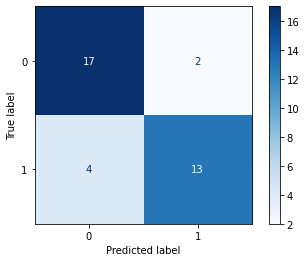

<Figure size 576x432 with 0 Axes>

In [356]:
print('Test set evaluation')
evaluate_model(best_logistic_reg_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [357]:
# extract feature importances
#feature_importances = np.abs(best_logistic_reg.coef_).sum(axis=0)

#print("Feature Importances:")
#for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

Logistic Regression for Men

In [358]:
logistic_reg = LogisticRegression(max_iter=1000, random_state=15, solver='liblinear')

grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 100, 'penalty': 'l1'}


In [359]:
best_logistic_reg_men = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=15)
best_logistic_reg_men.fit(X_train_men, y_train_men)

LogisticRegression(C=100, max_iter=1000, penalty='l1', random_state=15,
                   solver='liblinear')

Evaluation metrics for men:
Accuracy: 0.9215686274509803
Precision: 0.875
Recall: 0.9545454545454546
F1 Score: 0.9130434782608695
ROC AUC Score: 0.9255485893416928


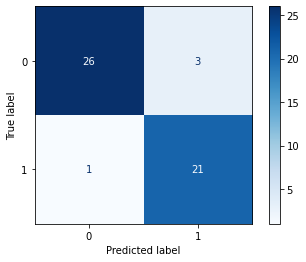

<Figure size 576x432 with 0 Axes>

In [360]:
evaluate_model(best_logistic_reg_men, X_val_men, y_val_men, 'men', best_params=best_params)

In [361]:
cross_validation(best_logistic_reg_men, X_train_men, y_train_men, 'men', kf=kf)

Cross-Validation Accuracy Scores:
[1.         0.94736842 0.94444444 0.94444444 1.        ]
Mean CV Accuracy: 0.967251461988304


Test set evaluation
Evaluation metrics for men:
Accuracy: 0.9166666666666666
Precision: 0.875
Recall: 0.9333333333333333
F1 Score: 0.9032258064516129
ROC AUC Score: 0.919047619047619


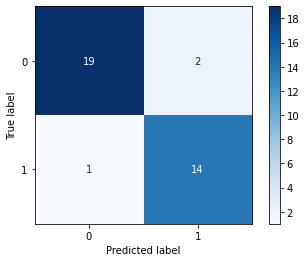

<Figure size 576x432 with 0 Axes>

In [362]:
print('Test set evaluation')
evaluate_model(best_logistic_reg_men, X_test_men, y_test_men, 'men', best_params=best_params)

Random Forest

In [363]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

Random Forest for Women

In [364]:
rf_classifier = RandomForestClassifier(random_state=15)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [365]:
best_rf_classifier_women = RandomForestClassifier(**best_params, random_state=15)
best_rf_classifier_women.fit(X_train_women, y_train_women)

RandomForestClassifier(min_samples_split=5, random_state=15)

Evaluation metrics for women:
Accuracy: 0.84
Precision: 0.7857142857142857
Recall: 0.9166666666666666
F1 Score: 0.8461538461538461
ROC AUC Score: 0.8429487179487177


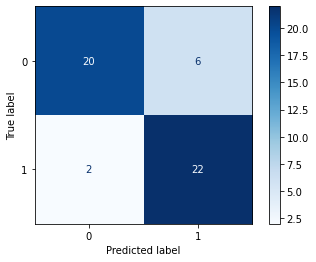

<Figure size 576x432 with 0 Axes>

In [366]:
evaluate_model(best_rf_classifier_women, X_val_women, y_val_women, 'women', best_params=best_params)

In [367]:
cross_validation(best_rf_classifier_women, X_train_women, y_train_women, 'women', kf=kf)

Cross-Validation Accuracy Scores:
[0.73684211 0.83333333 0.88888889 0.94444444 0.88888889]
Mean CV Accuracy: 0.8584795321637426


Test set evaluation
Evaluation metrics for women:
Accuracy: 0.8611111111111112
Precision: 0.9285714285714286
Recall: 0.7647058823529411
F1 Score: 0.8387096774193549
ROC AUC Score: 0.8560371517027864


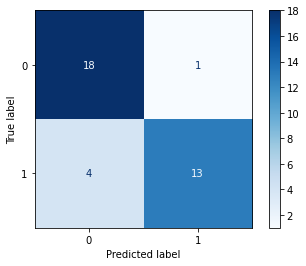

<Figure size 576x432 with 0 Axes>

In [368]:
print('Test set evaluation')
evaluate_model(best_rf_classifier_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [369]:
#feature_importances = best_rf_classifier.feature_importances_
#for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

Random Forest for Men

In [370]:
rf_classifier = RandomForestClassifier(random_state=15)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


In [371]:
best_rf_classifier_men = RandomForestClassifier(**best_params, random_state=15)
best_rf_classifier_men.fit(X_train_men, y_train_men)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=15)

Evaluation metrics for men:
Accuracy: 0.9411764705882353
Precision: 0.9130434782608695
Recall: 0.9545454545454546
F1 Score: 0.9333333333333332
ROC AUC Score: 0.9427899686520376


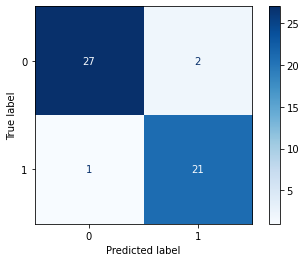

<Figure size 576x432 with 0 Axes>

In [372]:
evaluate_model(best_rf_classifier_men, X_val_men, y_val_men, 'men', best_params=best_params)

In [373]:
cross_validation(best_rf_classifier_men, X_train_men, y_train_men, 'men', kf=kf)

Cross-Validation Accuracy Scores:
[0.89473684 0.94736842 0.88888889 0.88888889 0.94444444]
Mean CV Accuracy: 0.9128654970760234


Test set evaluation
Evaluation metrics for men:
Accuracy: 0.9444444444444444
Precision: 0.8823529411764706
Recall: 1.0
F1 Score: 0.9375
ROC AUC Score: 0.9523809523809523


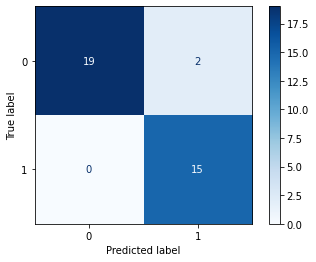

<Figure size 576x432 with 0 Axes>

In [374]:
print('Test set evaluation')
evaluate_model(best_rf_classifier_men, X_test_men, y_test_men, 'men', best_params=best_params)

Decision Trees

In [375]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

Decision Trees for Women

In [376]:
dec_tree_classifier = DecisionTreeClassifier(random_state=15)

grid_search = GridSearchCV(estimator=dec_tree_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}


In [377]:
best_dec_tree_classifier_women = DecisionTreeClassifier(**best_params, random_state=15)
best_dec_tree_classifier_women.fit(X_train_women, y_train_women)

DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=4,
                       random_state=15)

Evaluation metrics for women:
Accuracy: 0.76
Precision: 0.6875
Recall: 0.9166666666666666
F1 Score: 0.7857142857142857
ROC AUC Score: 0.7660256410256411


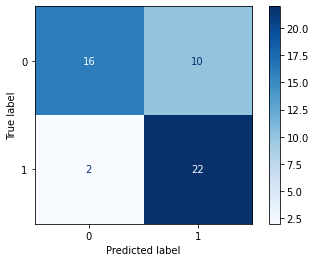

<Figure size 576x432 with 0 Axes>

In [378]:
evaluate_model(best_dec_tree_classifier_women, X_val_women, y_val_women, 'women', best_params=best_params)

In [379]:
cross_validation(best_dec_tree_classifier_women, X_train_women, y_train_women, 'women', kf=kf)

Cross-Validation Accuracy Scores:
[0.68421053 0.72222222 0.83333333 0.77777778 0.77777778]
Mean CV Accuracy: 0.7590643274853801


Test set evaluation
Evaluation metrics for women:
Accuracy: 0.8333333333333334
Precision: 0.8235294117647058
Recall: 0.8235294117647058
F1 Score: 0.8235294117647058
ROC AUC Score: 0.8328173374613003


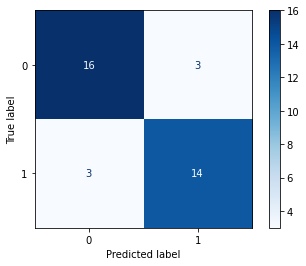

<Figure size 576x432 with 0 Axes>

In [380]:
print('Test set evaluation')
evaluate_model(best_dec_tree_classifier_women, X_test_women, y_test_women, 'women', best_params=best_params)

Decision Trees for Men

In [381]:
dec_tree_classifier = DecisionTreeClassifier(random_state=15)

grid_search = GridSearchCV(estimator=dec_tree_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [382]:
best_dec_tree_classifier_men = DecisionTreeClassifier(**best_params, random_state=15)
best_dec_tree_classifier_men.fit(X_train_men, y_train_men)

DecisionTreeClassifier(min_samples_leaf=2, random_state=15)

Evaluation metrics for men:
Accuracy: 0.9215686274509803
Precision: 0.9090909090909091
Recall: 0.9090909090909091
F1 Score: 0.9090909090909091
ROC AUC Score: 0.9200626959247649


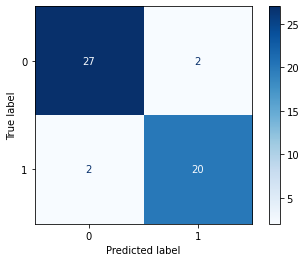

<Figure size 576x432 with 0 Axes>

In [383]:
evaluate_model(best_dec_tree_classifier_men, X_val_men, y_val_men, 'men', best_params=best_params)

In [384]:
cross_validation(best_dec_tree_classifier_men, X_train_men, y_train_men, 'men', kf=kf)

Cross-Validation Accuracy Scores:
[0.89473684 1.         0.83333333 0.77777778 0.94444444]
Mean CV Accuracy: 0.8900584795321638


Test set evaluation
Evaluation metrics for men:
Accuracy: 0.8888888888888888
Precision: 0.8666666666666667
Recall: 0.8666666666666667
F1 Score: 0.8666666666666667
ROC AUC Score: 0.8857142857142857


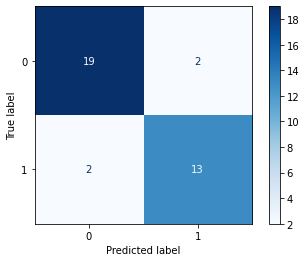

<Figure size 576x432 with 0 Axes>

In [385]:
print('Test set evaluation')
evaluate_model(best_dec_tree_classifier_men, X_test_men, y_test_men, 'men', best_params=best_params)

Support Vector Machine (SVM)

In [386]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}  

SVM for Women

In [387]:
svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}


In [388]:
best_svm_women = SVC(**best_params, random_state=15)
best_svm_women.fit(X_train_women, y_train_women)

SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=15)

Evaluation metrics for women:
Accuracy: 0.84
Precision: 0.7666666666666667
Recall: 0.9583333333333334
F1 Score: 0.8518518518518519
ROC AUC Score: 0.8445512820512822


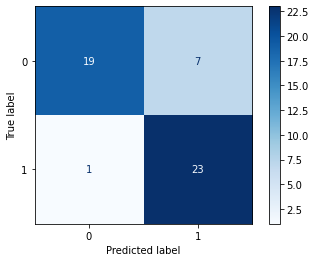

<Figure size 576x432 with 0 Axes>

In [389]:
evaluate_model(best_svm_women, X_val_women, y_val_women, 'women', best_params=best_params)

In [390]:
cross_validation(best_svm_women, X_train_women, y_train_women, 'women', kf=kf)

Cross-Validation Accuracy Scores:
[0.78947368 0.88888889 0.83333333 0.94444444 0.88888889]
Mean CV Accuracy: 0.8690058479532162


Test set evaluation
Evaluation metrics for women:
Accuracy: 0.8611111111111112
Precision: 0.8333333333333334
Recall: 0.8823529411764706
F1 Score: 0.8571428571428571
ROC AUC Score: 0.8622291021671826


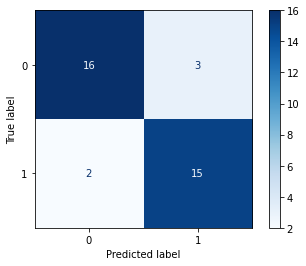

<Figure size 576x432 with 0 Axes>

In [391]:
print('Test set evaluation')
evaluate_model(best_svm_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [392]:
#perm_importance = permutation_importance(best_svm, X_train_women, y_train_women, n_repeats=10, random_state=15)
#feature_importance_scores = perm_importance.importances_mean
#for importance, feature in sorted(zip(feature_importance_scores, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

SVM for Men

In [393]:
svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}


In [394]:
best_svm_men = SVC(**best_params, random_state=15)
best_svm_men.fit(X_train_men, y_train_men)

SVC(C=1, gamma=0.01, kernel='poly', random_state=15)

Evaluation metrics for men:
Accuracy: 0.9215686274509803
Precision: 0.875
Recall: 0.9545454545454546
F1 Score: 0.9130434782608695
ROC AUC Score: 0.9255485893416928


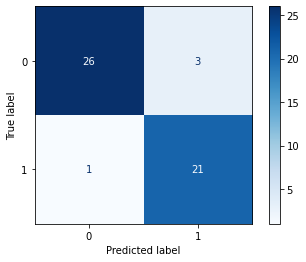

<Figure size 576x432 with 0 Axes>

In [395]:
evaluate_model(best_svm_men, X_val_men, y_val_men, 'men', best_params=best_params)

In [396]:
cross_validation(best_svm_men, X_train_men, y_train_men, 'men', kf=kf)

Cross-Validation Accuracy Scores:
[1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


Test set evaluation
Evaluation metrics for men:
Accuracy: 0.9444444444444444
Precision: 0.9333333333333333
Recall: 0.9333333333333333
F1 Score: 0.9333333333333333
ROC AUC Score: 0.9428571428571428


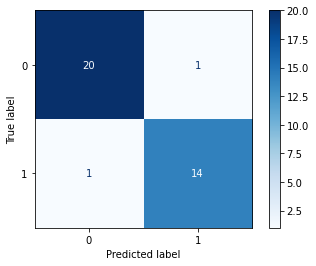

<Figure size 576x432 with 0 Axes>

In [397]:
print('Test set evaluation')
evaluate_model(best_svm_men, X_test_men, y_test_men, 'men', best_params=best_params)

K-Nearest Neighbours

In [398]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],     
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

K-Nearest Neighbours for Women

In [399]:
knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


In [400]:
best_knn_classifier_women = KNeighborsClassifier(**best_params)
best_knn_classifier_women.fit(X_train_women, y_train_women)

KNeighborsClassifier(metric='manhattan', n_neighbors=9)

Evaluation metrics for women:
Accuracy: 0.84
Precision: 0.7666666666666667
Recall: 0.9583333333333334
F1 Score: 0.8518518518518519
ROC AUC Score: 0.8445512820512822


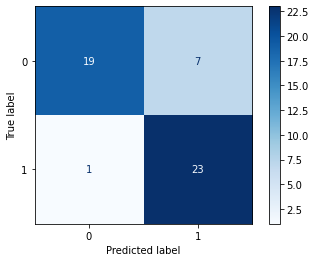

<Figure size 576x432 with 0 Axes>

In [401]:
evaluate_model(best_knn_classifier_women, X_val_women, y_val_women, 'women', best_params=best_params)

In [402]:
cross_validation(best_knn_classifier_women, X_train_women, y_train_women, 'women', kf=kf)

Cross-Validation Accuracy Scores:
[0.78947368 0.88888889 0.83333333 0.94444444 0.77777778]
Mean CV Accuracy: 0.8467836257309941


Test set evaluation
Evaluation metrics for women:
Accuracy: 0.8888888888888888
Precision: 0.8421052631578947
Recall: 0.9411764705882353
F1 Score: 0.8888888888888888
ROC AUC Score: 0.891640866873065


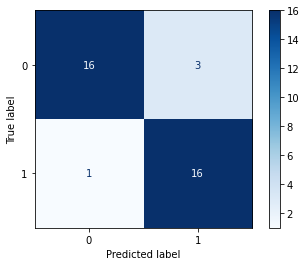

<Figure size 576x432 with 0 Axes>

In [403]:
print('Test set evaluation')
evaluate_model(best_knn_classifier_women, X_test_women, y_test_women, 'women', best_params=best_params)

K-Nearest Neighbours for Men

In [404]:
knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [405]:
best_knn_classifier_men = KNeighborsClassifier(**best_params)
best_knn_classifier_men.fit(X_train_men, y_train_men)

KNeighborsClassifier(metric='manhattan', weights='distance')

Evaluation metrics for men:
Accuracy: 0.9411764705882353
Precision: 0.88
Recall: 1.0
F1 Score: 0.9361702127659575
ROC AUC Score: 0.9482758620689655


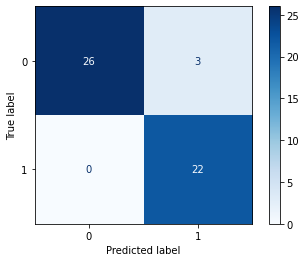

<Figure size 576x432 with 0 Axes>

In [406]:
evaluate_model(best_knn_classifier_men, X_val_men, y_val_men, 'men', best_params=best_params)

In [407]:
cross_validation(best_knn_classifier_men, X_train_men, y_train_men, 'men', kf=kf)

Cross-Validation Accuracy Scores:
[0.78947368 0.84210526 0.72222222 0.83333333 1.        ]
Mean CV Accuracy: 0.8374269005847953


Test set evaluation
Evaluation metrics for men:
Accuracy: 0.9166666666666666
Precision: 0.8333333333333334
Recall: 1.0
F1 Score: 0.9090909090909091
ROC AUC Score: 0.9285714285714286


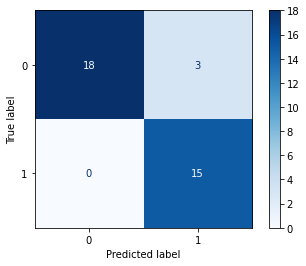

<Figure size 576x432 with 0 Axes>

In [408]:
print('Test set evaluation')
evaluate_model(best_knn_classifier_men, X_test_men, y_test_men, 'men', best_params=best_params)